In [1]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K

# from MD_AE_tools.models.models import *
from MD_AE_tools.models.models_no_bias import *
import MD_AE_tools.mode_decomposition as md
import myplot

import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from contextlib import redirect_stdout

import time
import os
import configparser
import datetime
import wandb

# get system information
config = configparser.ConfigParser()
config.read('_system.ini')
system_info = config['system_info']

# use gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[2],[tf.config.LogicalDeviceConfiguration(memory_limit=1024)]) # set hard memory limit
        # tf.config.experimental.set_memory_growth(gpus[0], True) # allow memory growth
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPU


2022-06-13 16:45:49.100017: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-13 16:45:50.711829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1024 MB memory:  -> device: 2, name: Quadro RTX 8000, pci bus id: 0000:a6:00.0, compute capability: 7.5


In [2]:
# data
data_file = './data/PIV4_downsampled_by8.h5'
Ntrain = 1500 # snapshots for training
Nval = 632 # sanpshots for validation
Ntest = 600

# Boolean 
LATENT_STATE = True # save latent state
SHUFFLE = True # shuffle before splitting into sets, test set is extracted before shuffling
REMOVE_MEAN = True # train on fluctuating velocity

## ae configuration
lmb = 0.001 #1e-05 #regulariser
drop_rate = 0.0
features_layers = [32, 64, 128]
latent_dim = 3
act_fct = 'linear'
resize_meth = 'bilinear'
filter_window= (5,5)
batch_norm = True

## training
nb_epoch = 3000
batch_size = 100
learning_rate = 0.001

Nz = 24 # grid size
Ny = 21
Nu = 2
Nt = 2732 # number of snapshots available
D = 196.5 # mm diameter of bluff body
U_inf = 15 # m/s freestream velocity
f_piv = 720.0 # Hz PIV sampling frequency  
dt = 1.0/f_piv 
Nx = [Ny, Nz]

In [3]:
#============================= READ DATA FROM FILE ================================
hf = h5py.File('./data/training_data_unshuffle_1.h5','r')
u_all = np.array(hf.get('u_all'))
u_train = np.array(hf.get('u_train'))
u_val = np.array(hf.get('u_val'))
u_test = np.array(hf.get('u_test'))
u_mean_all = np.array(hf.get('u_mean_all'))
u_mean_train = np.array(hf.get('u_mean_train'))
u_mean_val = np.array(hf.get('u_mean_val'))
u_mean_test = np.array(hf.get('u_mean_test'))
hf.close()

## pre-training linear

In [4]:
## define model
mdl_linear = MD_Autoencoder(Nx,Nu,features_layers=features_layers,latent_dim=latent_dim,
        filter_window=filter_window,act_fct='linear',batch_norm=batch_norm,
        drop_rate=drop_rate, lmb=lmb)
mdl_linear.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
mdl_linear.evaluate(u_train[0,:,:,:,:],u_train[0,:,:,:,:],verbose=0)

2022-06-13 16:46:38.588220: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8400
2022-06-13 16:46:40.353282: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2.433894395828247

In [9]:
mdl_linear.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21, 24, 2)]  0           []                               
                                                                                                  
 encoder (Encoder)              (None, 3)            261952      ['input_1[0][0]']                
                                                                                                  
 z_0 (Lambda)                   (None, 1)            0           ['encoder[0][0]']                
                                                                                                  
 z_1 (Lambda)                   (None, 1)            0           ['encoder[0][0]']                
                                                                                            

In [6]:
hist_train = []
hist_val = []

In [30]:
## training
pat = 200 # EarlyStopping
tempfn = './temp_pre-training-linear.h5'
model_cb=ModelCheckpoint(tempfn, monitor='val_loss',save_best_only=True,verbose=0,save_weights_only=True)
early_cb=EarlyStopping(monitor='val_loss', patience=pat,verbose=0)
cb = [model_cb, early_cb]

# mdl_linear.load_weights('./__experiments/pre-training-linear-1.h5')
# Training
hist0 = mdl_linear.fit(u_train[0,:,:,:,:], u_train[0,:,:,:,:],
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(u_val[0,:,:,:,:], u_val[0,:,:,:,:]),
                callbacks=cb,verbose=2)  
hist_train.extend(hist0.history['loss'])
hist_val.extend(hist0.history['val_loss'])

Epoch 1/3000
15/15 - 1s - loss: 1.4330 - val_loss: 1.3376 - 656ms/epoch - 44ms/step
Epoch 2/3000
15/15 - 0s - loss: 1.4283 - val_loss: 1.3422 - 480ms/epoch - 32ms/step
Epoch 3/3000
15/15 - 1s - loss: 1.4288 - val_loss: 1.3338 - 592ms/epoch - 39ms/step
Epoch 4/3000
15/15 - 0s - loss: 1.4301 - val_loss: 1.3355 - 474ms/epoch - 32ms/step
Epoch 5/3000
15/15 - 0s - loss: 1.4296 - val_loss: 1.3406 - 445ms/epoch - 30ms/step
Epoch 6/3000
15/15 - 0s - loss: 1.4280 - val_loss: 1.3371 - 491ms/epoch - 33ms/step
Epoch 7/3000
15/15 - 0s - loss: 1.4296 - val_loss: 1.3365 - 482ms/epoch - 32ms/step
Epoch 8/3000
15/15 - 0s - loss: 1.4283 - val_loss: 1.3388 - 489ms/epoch - 33ms/step
Epoch 9/3000
15/15 - 0s - loss: 1.4277 - val_loss: 1.3351 - 489ms/epoch - 33ms/step
Epoch 10/3000
15/15 - 0s - loss: 1.4286 - val_loss: 1.3385 - 492ms/epoch - 33ms/step
Epoch 11/3000
15/15 - 0s - loss: 1.4275 - val_loss: 1.3341 - 490ms/epoch - 33ms/step
Epoch 12/3000
15/15 - 1s - loss: 1.4265 - val_loss: 1.3364 - 500ms/epoch -

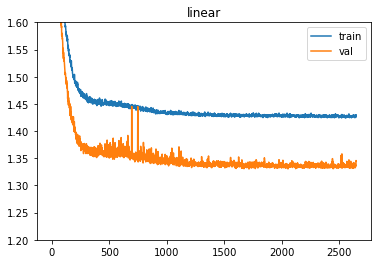

In [31]:
plt.figure()
plt.title('linear')
plt.plot(hist_train,label='train')
plt.plot(hist_val,label='val')
plt.ylim([1.2,1.6])
# plt.xlim([1500,2000])
plt.legend()
plt.show()

In [32]:
mdl_linear.load_weights(tempfn)
print('best training loss:',mdl_linear.evaluate(u_train[0,:,:,:,:],u_train[0,:,:,:,:],verbose=0))

best training loss: 1.4212753772735596


In [33]:
# get ae modes from training or testing set
which = 'train'

latent_test = mdl_linear.encoder.predict(u_test[0,:,:,:,:])
latent_train = mdl_linear.encoder.predict(u_train[0,:,:,:,:])
linear_decoders = []

if which == 'train':
    z_l = latent_train
    u_in_l = u_train[0,:,:,:,:]
elif which == 'test':
    z_l = latent_test
    u_in_l = u_test[0,:,:,:,:]

for name in mdl_linear.name_decoder:
    linear_decoders.append(mdl_linear.get_layer(name))
linear_modes = []
for i in range(latent_dim):
    linear_modes.append(linear_decoders[i].predict(np.reshape(z_l[:,i],(-1,1))))
linear_modes = np.array(linear_modes)
y_test_sum = np.sum(linear_modes,axis=0)
    
y_test = mdl_linear.predict(u_in_l)

print('Are results calculated the two ways the same?',np.array_equal(y_test_sum,y_test))

loss_test_1 = mdl_linear.evaluate(u_in_l,u_in_l,verbose=0)
loss_test_2 = tf.keras.losses.MeanSquaredError()(u_in_l,y_test)
print('total loss:',loss_test_1,'    mse loss:',loss_test_2.numpy())

Are results calculated the two ways the same? True
total loss: 1.4212753772735596     mse loss: 1.4168563


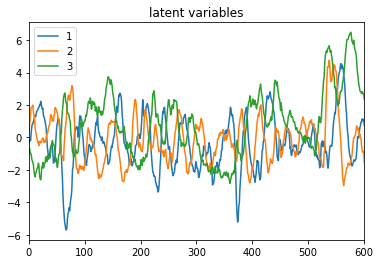

In [47]:
plt.figure()
for z in range(latent_dim):
    # plt.plot(latent_test[:,z],label=str(z+1))
    plt.plot(latent_train[:,z],label=str(z+1))
plt.xlim([0,600])
plt.title('latent variables')
plt.legend()
plt.show()

variance: [2.7367008 1.9150159 4.68404  ]  rank: [3 1 2]


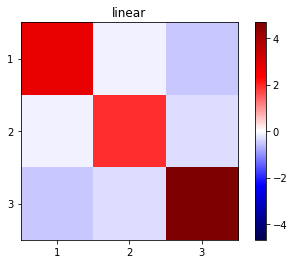

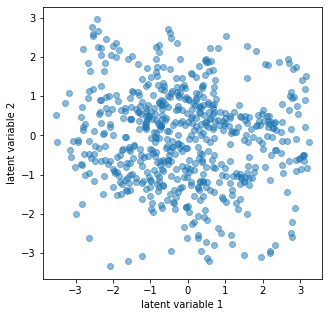

covariance sum [3 1 2]
determinant of corr matrix:  0.8863259718167998


In [35]:
# cov = latent_test.T@latent_test/(Ntest-1)
cov = latent_train.T@latent_train/(Ntrain-1)
# cov = np.cov(latent_test.T)
vmax = np.max(cov)
plt.figure()
plt.title('linear')
plt.imshow(cov,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,latent_dim+0.5,latent_dim+0.5,0.5]) # vmin=-1,vmax=1,
plt.xticks(np.arange(latent_dim)+1)
plt.yticks(np.arange(latent_dim)+1)
plt.colorbar()

sort_idx = np.argsort(np.diag(cov))
rank_var = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('variance:',np.diag(cov),' rank:',rank_var)

# compare two variables
pltz = [0,1]
plt.figure(figsize=(5,5))
plt.scatter(latent_test[:,pltz[0]],latent_test[:,pltz[1]],alpha=0.5)
plt.xlabel("latent variable %i"%(pltz[0]+1))
plt.ylabel("latent variable %i"%(pltz[1]+1))
# plt.xlim([-10,10])
# plt.ylim([-10,10])
# plt.plot([0,0.45391235],[0,0.89104634],linewidth=3,color='r')
# plt.plot([0,-0.89104634],[0,0.45391235],linewidth=3,color='r')
plt.show()
covar_sum = np.sum(abs(cov-np.diag(np.diag(cov))),axis=0)
sort_idx = np.argsort(covar_sum)
rank_cov = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('covariance sum',rank_cov)

det = np.linalg.det(np.corrcoef(latent_test.T))
print('determinant of corr matrix: ',det) 

In [36]:
pod_1 = md.POD(latent_train.T,method='classic')
m_1,lam_1 = pod_1.get_modes()
print(m_1,lam_1)

Calculating POD ...
User has selected classic POD
POD done.
[[-0.2538816   0.94532307 -0.20471546]
 [-0.09908497 -0.23595543 -0.96669913]
 [ 0.96214671  0.2251429  -0.15357205]] [4.06055331 2.66415364 1.84217008]


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:189: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


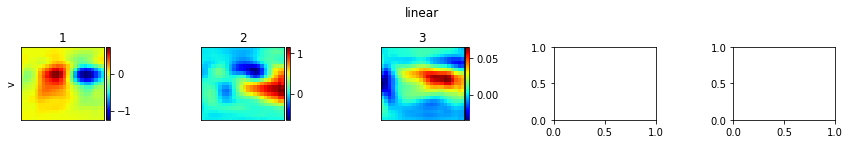

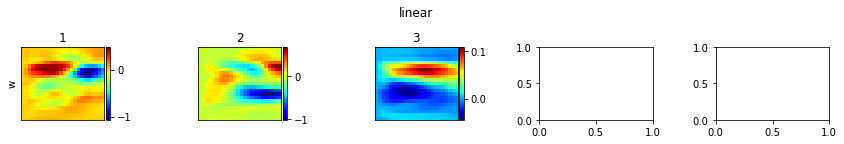

In [37]:
fig,ax = plt.subplots(1,5,figsize=(12,2))
fig.suptitle('linear')
ax[0].set_ylabel('v')
for i, ax in enumerate(fig.axes):
    if i < len(linear_decoders):
        m = linear_decoders[i].predict(np.reshape(1,(1,1)))
        im = ax.imshow(m[0,:,:,0],'jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i+1))
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(im,cax=cax)
plt.tight_layout()
        

fig,ax = plt.subplots(1,5,figsize=(12,2))
fig.suptitle('linear')
ax[0].set_ylabel('w')
for i, ax in enumerate(fig.axes):
    if i < len(linear_decoders):
        m = linear_decoders[i].predict(np.reshape(1,(1,1)))
        im = ax.imshow(m[0,:,:,1],'jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i+1))
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(im,cax=cax)
plt.tight_layout()

In [21]:
for i in range(latent_dim):
    print('mse loss ae mode %i:'%(i+1),tf.keras.losses.MeanSquaredError()(u_in_l,linear_modes[i,:,:,:,:]).numpy())

mse loss ae mode 1: 1.7475051
mse loss ae mode 2: 1.7672814
mse loss ae mode 3: 1.6905595


## nonlinear before training

In [38]:
mdl_nonlinear = MD_Autoencoder(Nx,Nu,features_layers=features_layers,latent_dim=latent_dim,
        filter_window=filter_window,act_fct='tanh',batch_norm=batch_norm,
        drop_rate=drop_rate, lmb=lmb)

In [39]:
mdl_nonlinear.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 21, 24, 2)]  0           []                               
                                                                                                  
 encoder_1 (Encoder)            (None, 3)            261952      ['input_6[0][0]']                
                                                                                                  
 z_0 (Lambda)                   (None, 1)            0           ['encoder_1[0][0]']              
                                                                                                  
 z_1 (Lambda)                   (None, 1)            0           ['encoder_1[0][0]']              
                                                                                            

In [40]:
# load weights
mdl_nonlinear.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
mdl_nonlinear.evaluate(u_train[0,:,:,:,:],u_train[0,:,:,:,:],verbose=0)
mdl_nonlinear.load_weights('temp_pre-training-linear.h5')
print('training loss after loading weights from linear pre-training:',mdl_nonlinear.evaluate(u_train[0,:,:,:,:],u_train[0,:,:,:,:],verbose=0))

training loss after loading weights from linear pre-training: 1.7798538208007812


In [41]:
# get decoders
latent_test_2 = mdl_nonlinear.encoder.predict(u_test[0,:,:,:,:])
nonlinear_decoders = []
for name in mdl_nonlinear.name_decoder:
    nonlinear_decoders.append(mdl_nonlinear.get_layer(name))

nonlinear_modes = []
for i in range(latent_dim):
    nonlinear_modes.append(nonlinear_decoders[i].predict(np.reshape(latent_test_2[:,i],(-1,1))))
nonlinear_modes = np.array(linear_modes)

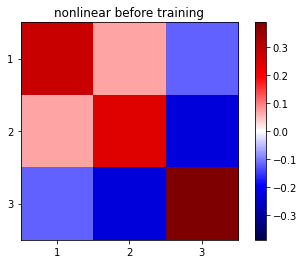

variance: [0.2754234  0.24181737 0.38984025]  rank: [3 1 2]


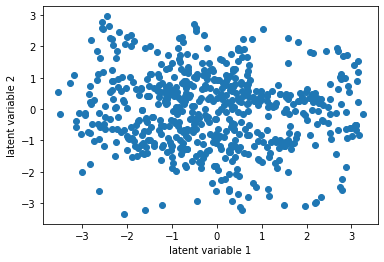

determinant of corr matrix:  0.9472023031733142


In [43]:
cov_2 = latent_test_2.T@latent_test_2/(Ntest-1)
# cov_2 = np.cov(latent_test.T)
vmax = np.max(cov_2)
plt.figure()
plt.title('nonlinear before training')
plt.imshow(cov_2,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,latent_dim+0.5,latent_dim+0.5,0.5]) # vmin=-1,vmax=1,
plt.xticks(np.arange(latent_dim)+1)
plt.yticks(np.arange(latent_dim)+1)
plt.colorbar()
plt.show()
sort_idx = np.argsort(np.diag(cov_2))
rank_var_2 = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('variance:',np.diag(cov_2),' rank:',rank_var_2)

# compare two variables
pltz = [0,1]
plt.figure()
plt.scatter(latent_test[:,pltz[0]],latent_test[:,pltz[1]])
plt.xlabel("latent variable %i"%(pltz[0]+1))
plt.ylabel("latent variable %i"%(pltz[1]+1))
plt.show()

det_2 = np.linalg.det(np.corrcoef(latent_test_2.T))
print('determinant of corr matrix: ',det_2) 

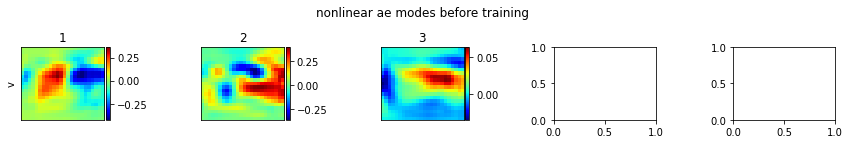

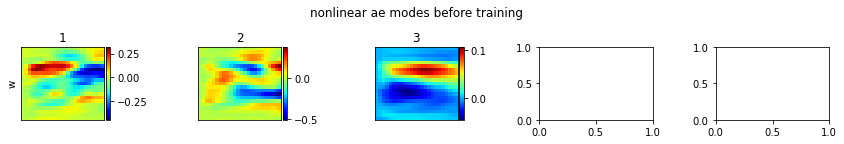

In [48]:
fig,ax = plt.subplots(1,5,figsize=(12,2))
fig.suptitle('nonlinear ae modes before training')
ax[0].set_ylabel('v')
for i, ax in enumerate(fig.axes):
    if i < len(nonlinear_decoders):
        m = nonlinear_decoders[i].predict(np.reshape(1,(1,1)))
        im = ax.imshow(m[0,:,:,0],'jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i+1))
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(im,cax=cax)
plt.tight_layout()

fig,ax = plt.subplots(1,5,figsize=(12,2))
fig.suptitle('nonlinear ae modes before training')
ax[0].set_ylabel('w')
for i, ax in enumerate(fig.axes):
    if i < len(nonlinear_decoders):
        m = nonlinear_decoders[i].predict(np.reshape(1,(1,1)))
        im = ax.imshow(m[0,:,:,1],'jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i+1))
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(im,cax=cax)
plt.tight_layout()

plt.show()

Calculating POD ...
Use classic POD, Nx <= Nt.
POD done.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:189: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


spectrum (first 5):  [0.99999998 0.99999999 0.99999999 0.99999999 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]


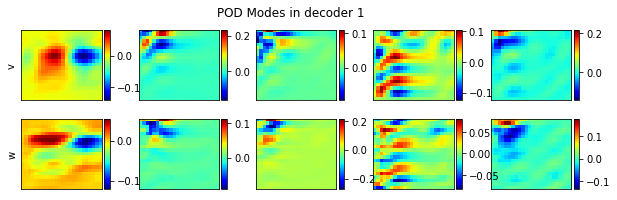

In [50]:
## decompose ae modes
which_decoder = 1-1
# PlotWhichVelocity = 'v' 
save_img = False
vy = nonlinear_modes[which_decoder,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = nonlinear_modes[which_decoder,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
# POD
pod = md.POD(X)
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean


## plot POD
fig1 = plt.figure(figsize=(10, 3))
title = "POD Modes in decoder " + str(which_decoder+1)
plt.suptitle(title)

# v
grid0 = ImageGrid(fig1,211,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid0.axes_llc.set_xticks([])
grid0.axes_llc.set_yticks([])
grid0.axes_llc.set_ylabel('v')
iphi = 0
for ax, cax in zip(grid0, grid0.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[Ny:,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1
# w
grid1 = ImageGrid(fig1,212,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid1.axes_llc.set_xticks([])
grid1.axes_llc.set_yticks([])
grid1.axes_llc.set_ylabel('w')
iphi = 0
for ax, cax in zip(grid1, grid1.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[0:Ny,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1


## Spectrum
energy_1 = np.cumsum(lam/np.sum(lam))
print('spectrum (first 5): ', energy_1[:15])


plt.show()

## nonlinear after training

In [51]:
hist_train_3 = []
hist_val_3 = []

In [52]:
pat = 200 # EarlyStopping
tempfn = './temp_training-nonlinear.h5'
model_cb=ModelCheckpoint(tempfn, monitor='val_loss',save_best_only=True,verbose=0,save_weights_only=True)
early_cb=EarlyStopping(monitor='val_loss', patience=pat,verbose=0)
cb = [model_cb, early_cb]

# mdl_nonlinear.load_weights('./temp_training-nonlinear.h5')
# Training
hist0 = mdl_nonlinear.fit(u_train[0,:,:,:,:], u_train[0,:,:,:,:],
                epochs=nb_epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(u_val[0,:,:,:,:], u_val[0,:,:,:,:]),
                callbacks=cb,verbose=2)  
hist_train_3.extend(hist0.history['loss'])
hist_val_3.extend(hist0.history['val_loss'])

Epoch 1/3000
15/15 - 3s - loss: 1.5569 - val_loss: 1.6492 - 3s/epoch - 186ms/step
Epoch 2/3000
15/15 - 0s - loss: 1.4883 - val_loss: 1.7155 - 484ms/epoch - 32ms/step
Epoch 3/3000
15/15 - 0s - loss: 1.4518 - val_loss: 1.7210 - 484ms/epoch - 32ms/step
Epoch 4/3000
15/15 - 0s - loss: 1.4437 - val_loss: 1.7778 - 489ms/epoch - 33ms/step
Epoch 5/3000
15/15 - 0s - loss: 1.4436 - val_loss: 1.7582 - 486ms/epoch - 32ms/step
Epoch 6/3000
15/15 - 0s - loss: 1.4347 - val_loss: 1.7750 - 496ms/epoch - 33ms/step
Epoch 7/3000
15/15 - 0s - loss: 1.4349 - val_loss: 1.7880 - 425ms/epoch - 28ms/step
Epoch 8/3000
15/15 - 0s - loss: 1.4324 - val_loss: 1.7637 - 458ms/epoch - 31ms/step
Epoch 9/3000
15/15 - 0s - loss: 1.4318 - val_loss: 1.7873 - 468ms/epoch - 31ms/step
Epoch 10/3000
15/15 - 0s - loss: 1.4273 - val_loss: 1.7103 - 484ms/epoch - 32ms/step
Epoch 11/3000
15/15 - 0s - loss: 1.4276 - val_loss: 1.7136 - 479ms/epoch - 32ms/step
Epoch 12/3000
15/15 - 0s - loss: 1.4231 - val_loss: 1.7734 - 454ms/epoch - 3

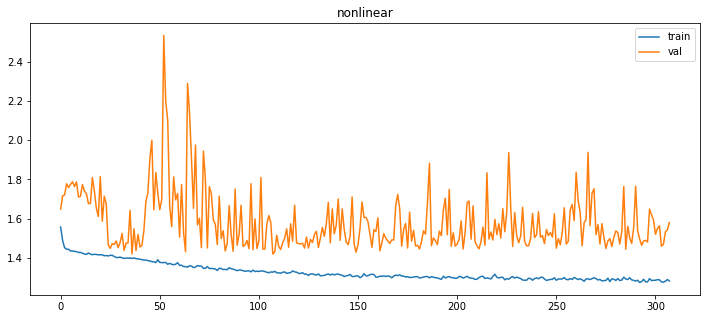

In [54]:
plt.figure(figsize=(12,5))
plt.title('nonlinear')
plt.plot(hist_train_3,label='train')
plt.plot(hist_val_3,label='val')
plt.legend()
plt.show()

In [55]:
# get ae modes from training or testing
which = 'train'


mdl_nonlinear.load_weights('./temp_training-nonlinear.h5')
latent_test_3 = mdl_nonlinear.encoder.predict(u_test[0,:,:,:,:])
latent_train_3 = mdl_nonlinear.encoder.predict(u_train[0,:,:,:,:])
nonlinear_decoders_trained = []
for name in mdl_nonlinear.name_decoder:
    nonlinear_decoders_trained.append(mdl_nonlinear.get_layer(name))
nonlinear_modes_trained = []

if which == 'train':
    z = latent_train_3
    u_in = u_train[0,:,:,:,:]
elif which == 'test':
    z = latent_test_3
    u_in = u_test[0,:,:,:,:]

for i in range(latent_dim):
    nonlinear_modes_trained.append(nonlinear_decoders_trained[i].predict(np.reshape(z[:,i],(-1,1))))
nonlinear_modes_trained = np.array(nonlinear_modes_trained)
y_test_sum = np.sum(nonlinear_modes_trained,axis=0)
    
y_test = mdl_nonlinear.predict(u_in)

print('Are results calculated the two ways the same?',np.array_equal(y_test_sum,y_test))
loss_test_1 = mdl_nonlinear.evaluate(u_in,u_in,verbose=0)
loss_test_2 = tf.keras.losses.MeanSquaredError()(u_in,y_test)
print('total loss:',loss_test_1,'    mse loss:',loss_test_2.numpy())

Are results calculated the two ways the same? True
total loss: 1.3241260051727295     mse loss: 1.3051246


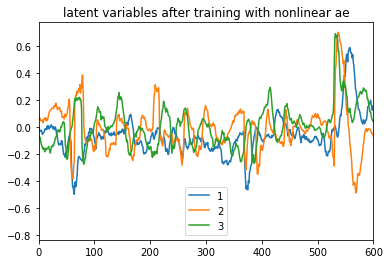

In [58]:
plt.figure()
for i in range(latent_dim):
    # plt.plot(latent_test_3[:,i],label=str(i+1))
    plt.plot(latent_train_3[:,i],label=str(i+1))
plt.xlim([0,600])
plt.title('latent variables after training with nonlinear ae')
plt.legend()
plt.show()

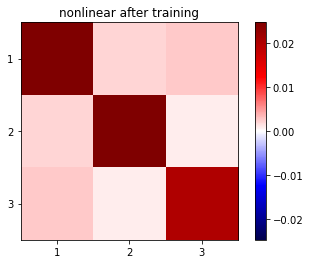

variance: [0.02472945 0.02466187 0.02006857]  rank: [1 2 3]


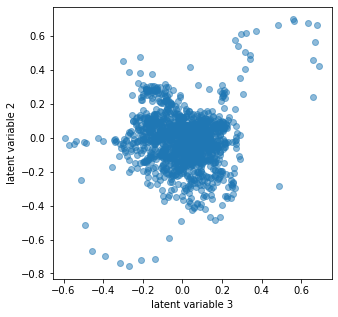

determinant of corr matrix:  0.9764426709588813


In [57]:
cov_3 = z.T@z/(z.shape[0]-1)
# cov_3 = np.cov(z.T)
vmax = np.max(cov_3)
plt.figure()
plt.title('nonlinear after training')
plt.imshow(cov_3,cmap='seismic',vmin=-vmax,vmax=vmax,extent=[0.5,latent_dim+0.5,latent_dim+0.5,0.5]) # vmin=-1,vmax=1,
plt.xticks(np.arange(latent_dim)+1)
plt.yticks(np.arange(latent_dim)+1)
plt.colorbar()
plt.show()
sort_idx = np.argsort(np.diag(cov_3))
rank_var_3 = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print('variance:',np.diag(cov_3),' rank:',rank_var_3)

# compare two variables
pltz = [2,1]
plt.figure(figsize=(5,5))
plt.scatter(z[:,pltz[0]],z[:,pltz[1]],alpha=0.5)
plt.xlabel("latent variable %i"%(pltz[0]+1))
plt.ylabel("latent variable %i"%(pltz[1]+1))
# plt.xlim([-1,1])
# plt.ylim([-1,1])
# plt.plot([0,-0.89021688],[0,-0.45553694],linewidth=3,color='k',label='new eigenvectors')
# plt.plot([0,0.45553694],[0,-0.89021688],linewidth=3,color='k')
# plt.plot([0,0.45391235],[0,0.89104634],linewidth=3,color='r',label='old eigenvectors')
# plt.plot([0,-0.89104634],[0,0.45391235],linewidth=3,color='r')
# plt.legend()
plt.show()

det_3 = np.linalg.det(np.corrcoef(z.T))
print('determinant of corr matrix: ',det_3) 

In [59]:
pod_1 = md.POD(z.T,method='classic')
m_1,lam_1 = pod_1.get_modes()
print(m_1,lam_1)

Calculating POD ...
User has selected classic POD
POD done.
[[-0.4693845   0.61296572  0.63557157]
 [-0.80383195 -0.59451053 -0.0202836 ]
 [-0.36542084  0.52041354 -0.77177546]] [0.02565203 0.02246993 0.01769326]


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:189: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


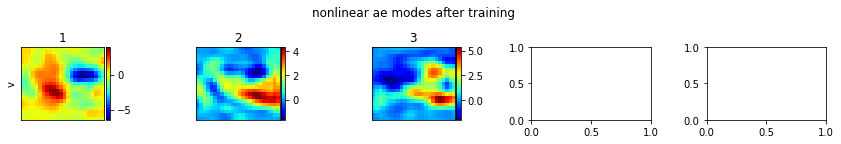

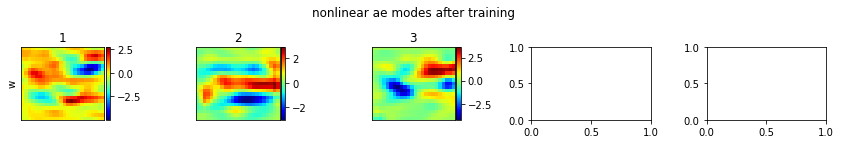

In [60]:
fig,ax = plt.subplots(1,5,figsize=(12,2))
fig.suptitle('nonlinear ae modes after training')
ax[0].set_ylabel('v')
for i, ax in enumerate(fig.axes):
    if i < len(nonlinear_decoders):
        m = nonlinear_decoders[i].predict(np.reshape(1,(1,1)))
        im = ax.imshow(m[0,:,:,0],'jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i+1))
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(im,cax=cax)
plt.tight_layout()
        

fig,ax = plt.subplots(1,5,figsize=(12,2))
fig.suptitle('nonlinear ae modes after training')
ax[0].set_ylabel('w')
for i, ax in enumerate(fig.axes):
    if i < len(nonlinear_decoders):
        m = nonlinear_decoders[i].predict(np.reshape(1,(1,1)))
        im = ax.imshow(m[0,:,:,1],'jet')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(str(i+1))
        ax_divider = make_axes_locatable(ax)
        cax = ax_divider.append_axes("right", size="5%", pad="2%")
        plt.colorbar(im,cax=cax)
plt.tight_layout()

In [1]:
## decompose ae modes
which_decoder = 3-1
PlotWhichVelocity = 'v' 
save_img = False
vy = nonlinear_modes_trained[which_decoder,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = nonlinear_modes_trained[which_decoder,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
# POD
pod = md.POD(X)
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean


## plot POD
fig1 = plt.figure(figsize=(10, 3))
title = "POD Modes in decoder " + str(which_decoder+1)
plt.suptitle(title)

# v
grid0 = ImageGrid(fig1,211,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid0.axes_llc.set_xticks([])
grid0.axes_llc.set_yticks([])
grid0.axes_llc.set_ylabel('v')
iphi = 0
for ax, cax in zip(grid0, grid0.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[Ny:,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1
# w
grid1 = ImageGrid(fig1,212,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid1.axes_llc.set_xticks([])
grid1.axes_llc.set_yticks([])
grid1.axes_llc.set_ylabel('w')
iphi = 0
for ax, cax in zip(grid1, grid1.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[0:Ny,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1


## Spectrum
energy_1 = np.cumsum(lam/np.sum(lam))
print('spectrum (first 5): ', energy_1[:15])


plt.show()

NameError: name 'nonlinear_modes_trained' is not defined

In [ ]:
## decompose ae modes
which_decoder = 2-1
PlotWhichVelocity = 'v' 
save_img = False
vy = nonlinear_modes_trained[which_decoder,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = nonlinear_modes_trained[which_decoder,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
# POD
pod = md.POD(X)
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean


## plot POD
fig1 = plt.figure(figsize=(10, 3))
title = "POD Modes in decoder " + str(which_decoder+1)
plt.suptitle(title)

# v
grid0 = ImageGrid(fig1,211,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid0.axes_llc.set_xticks([])
grid0.axes_llc.set_yticks([])
grid0.axes_llc.set_ylabel('v')
iphi = 0
for ax, cax in zip(grid0, grid0.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[Ny:,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1
# w
grid1 = ImageGrid(fig1,212,share_all=True,nrows_ncols=(1, 5),axes_pad=0.4,label_mode="1",cbar_location="right",cbar_mode="each",cbar_size="7%",cbar_pad="3%")
grid1.axes_llc.set_xticks([])
grid1.axes_llc.set_yticks([])
grid1.axes_llc.set_ylabel('w')
iphi = 0
for ax, cax in zip(grid1, grid1.cbar_axes):
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    im = ax.imshow(pltV[0:Ny,:],'jet')
    cb = cax.colorbar(im)
    iphi += 1


## Spectrum
energy_2 = np.cumsum(lam/np.sum(lam))
print('spectrum (first 5): ', energy_2[:8])
plt.figure()
plt.plot(energy_1,label='1')
plt.plot(energy_2,label='2')
plt.title('spectrum')
plt.xlim([0,29])
plt.ylim([0.4,1.05])
plt.legend()

plt.show()

In [ ]:
print('mse loss ae mode 1:',tf.keras.losses.MeanSquaredError()(u_in,nonlinear_modes_trained[0,:,:,:,:]).numpy())
print('mse loss ae mode 2:',tf.keras.losses.MeanSquaredError()(u_in,nonlinear_modes_trained[1,:,:,:,:]).numpy())

## Ranking

In [32]:
# mse loss
mse = tf.keras.losses.MeanSquaredError()
modes_E = np.copy(nonlinear_modes_trained)
rank_mse = np.zeros(latent_dim,dtype='int')-1
for j in range(latent_dim):
    E_ref = 0
    for i in range(latent_dim):
        if i not in rank_mse:
            E = 1/mse(u_in,modes_E[i]).numpy()
            if E > E_ref:
                E_ref = E
                rank_mse[j] = i
    modes_E = nonlinear_modes_trained + modes_E[rank_mse[j]]
rank_mse += 1

i_mse = []
for i in range(latent_dim):
    i_mse.append(mse(u_in,nonlinear_modes_trained[i,:,:,:,:]).numpy())
sort_idx = np.argsort(i_mse)
rank_i_mse = np.arange(1,latent_dim+1)[sort_idx]

In [33]:
# number of POD modes to reach 99% energy u_mean_trainD modes
a = []
to99 = np.zeros(latent_dim,dtype='int')
for i in range(latent_dim):
    vy = nonlinear_modes_trained[i,:,:,:,0].astype('float64')
    vy = np.transpose(vy,[1,2,0])
    vz = nonlinear_modes_trained[i,:,:,:,1].astype('float64')
    vz = np.transpose(vz,[1,2,0]) #(ny,nz,nt)
    X_99 = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
    pod_99 = md.POD(X_99,method='classic')
    Q_POD_99,lam_99 = pod_99.get_modes()
    energy = np.cumsum(lam_99/np.sum(lam_99))
    a.append(energy[0])
    for j in range(len(energy)):
        if energy[j] >= 0.99:
            to99[i] = j+1
            break
print(to99)
sort_idx = np.argsort(to99)
rank_to99 = np.arange(1,latent_dim+1)[np.flip(sort_idx)]
print(rank_to99)

Calculating POD ...
User has selected classic POD
POD done.
Calculating POD ...
User has selected classic POD
POD done.
Calculating POD ...
User has selected classic POD
POD done.
[ 9 10  9]
[2 3 1]


In [34]:
# POD of data
vy = u_train[0,:,:,:,0] + u_mean_train[:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = u_train[0,:,:,:,1] + u_mean_train[:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy))

pod_data = md.POD(X,method='classic')
Q_POD_data,lam_data = pod_data.get_modes()
total_energy = np.sum(lam_data)

Calculating POD ...
User has selected classic POD
POD done.


In [35]:
# linear energy
a = []
for i in range(latent_dim):
    vy = nonlinear_modes_trained[i,:,:,:,0].astype('float64')
    vy = np.transpose(vy,[1,2,0])
    vz = nonlinear_modes_trained[i,:,:,:,1].astype('float64')
    vz = np.transpose(vz,[1,2,0])
    X_mode = np.vstack((vz,vy))
    nt = X_mode.shape[-1]
    X_mode = np.reshape(X_mode,(-1,nt))
    A = X_mode.T @ Q_POD_data #(nt,nx)
    lam_1 = np.sum(np.square(A),axis=0)/(nt-1)
    e = np.sum(lam_1)
    print("percentage linear energy of ae mode %i:  %0.3f"%(i+1,e*100/total_energy))
    a.append(e)
sort_idx = np.argsort(a)
rank_energy = np.arange(1,latent_dim+1)[np.flip(sort_idx)]

percentage linear energy of ae mode 1:  16.342
percentage linear energy of ae mode 2:  13.271
percentage linear energy of ae mode 3:  12.743


In [36]:
print('rank_variance:       ',rank_var_3)
print('rank_mse:            ',rank_mse)
print('rank_i_mse:          ',rank_i_mse)
print('rank_to99:           ',rank_to99)
print('rank_linear_energy:  ',rank_energy)

rank_variance:        [3 2 1]
rank_mse:             [1 2 3]
rank_i_mse:           [1 2 3]
rank_to99:            [2 3 1]
rank_linear_energy:   [1 2 3]
